In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple representation space tests with an FCN


## Imports


In [39]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from typing import List
from functools import partial

import os
import sys
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import equinox as eqx
import optax  # https://github.com/deepmind/optax
from jaxtyping import Array, Float, Int  # https://github.com/google/jaxtyping

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import r2_score  
                
import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


jax.devices()

[gpu(id=0), gpu(id=1)]

In [40]:
from src.models.mlp import MLP, MLP_fn
from src.losses.losses import loss_fn, compute_accuracy_categorical, compute_accuracy_regression
from src.utils.math import custom_round, convert_to_scientific_exponent
from src.utils.data_preprocessing import drop_duplicates_keep_first_n

In [41]:
# Make sure GPU is actually working
jnp.arange(9)

Array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

## Load data


In [42]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/ensemble_mutation_effect_analysis/2023_10_03_204819/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
try:
    data.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass
# for c in get_true_interaction_cols(data, interaction_attr='binding_sites_idxs', remove_symmetrical=True) + get_true_interaction_cols(
#         data, interaction_attr='binding_site_group_range', remove_symmetrical=True):
#     data[c] = data[c].map(ast.literal_eval)

## Hyperparameters


In [43]:
BATCH_SIZE = 128
N_BATCHES = 1200
TOTAL_DS = BATCH_SIZE * N_BATCHES
MAX_TOTAL_DS = TOTAL_DS
train_split_perc = 0.8
TRAIN_SPLIT = int(train_split_perc * TOTAL_DS)
TEST_SPLIT = TOTAL_DS - TRAIN_SPLIT
LEARNING_RATE = 1e-4
LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 1000
PRINT_EVERY = EPOCHS // 30
SEED = 1
INPUT_SPECIES = 'RNA_1'
target_circ_func = 'sensitivity_wrt_species-6'
input_concat_diffs = False
input_concat_axis = 0

# MLP Architecture
LAYER_SIZES = [64, 64, 64]
USE_CATEGORICAL = False
USE_DROPOUT = False
USE_L2_REG = False
USE_WARMUP = False

loss_fn = partial(
    loss_fn, loss_type='categorical' if USE_CATEGORICAL else 'mse', use_l2_reg=USE_L2_REG)
compute_accuracy = compute_accuracy_categorical if USE_CATEGORICAL else compute_accuracy_regression

subtask = 'best_'
save_path = 'saves_' + subtask + str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_')

rng = jax.random.PRNGKey(SEED)

## Initialise


### Input

To make sure that there is little repetition in the dataset, the uniqueness of each sample will be judged. For genetic circuits,there is a lot of sparsity, as most biological sequences do not interact. Therefore, there may be an overrepresentation of some circuit topologies.


In [44]:
vectorized_convert_to_scientific_exponent = np.vectorize(
    convert_to_scientific_exponent)
filt = data['sample_name'] == INPUT_SPECIES
numerical_resolution = 2

# Balance the dataset
df = drop_duplicates_keep_first_n(data[filt], get_true_interaction_cols(
    data, 'energies', remove_symmetrical=True), n=100)
df[target_circ_func] = df[target_circ_func].round(
    np.abs(int(f'{df[target_circ_func].min():.0e}'.split('e')[1]))-1)
df = drop_duplicates_keep_first_n(
    df, column=target_circ_func, n=200)

TOTAL_DS = np.min([TOTAL_DS, MAX_TOTAL_DS, len(df)])

In [45]:
TOTAL_DS

116888

In [50]:
x_cols = [get_true_interaction_cols(data, 'energies', remove_symmetrical=True)]
if input_concat_diffs:
    x_cols = x_cols + \
        [[f'{i}_diffs' for i in get_true_interaction_cols(
            data, k, remove_symmetrical=True)]]

x = [df[i].iloc[:TOTAL_DS].values[:, :, None] for i in x_cols]
x = np.concatenate(x, axis=input_concat_axis+1).squeeze()

y = df[target_circ_func].iloc[:TOTAL_DS].to_numpy()

if USE_CATEGORICAL:
    y_map = {k: numerical_resolution for k in np.arange(int(f'{y[y != 0].min():.0e}'.split(
        'e')[1])-1, np.max([int(f'{y.max():.0e}'.split('e')[1])+1, 0 + 1]))}
    y_map[-6] = 1
    y_map[-5] = 1
    y_map[-4] = 4
    y_map[-3] = 2
    y_map[-1] = 3
    y = jax.tree_util.tree_map(partial(
        vectorized_convert_to_scientific_exponent, numerical_resolution=y_map), y)
    y = np.interp(y, sorted(np.unique(y)), np.arange(
        len(sorted(np.unique(y))))).astype(int)
else:
    zero_log_replacement = -10.0
    y = np.where(y != 0, np.log10(y), zero_log_replacement)

x, y = shuffle(x, y, random_state=SEED)

N_HEAD = len(np.unique(y)) if USE_CATEGORICAL else 1


if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

/tmp/ipykernel_3642737/2536681470.py:26: RuntimeWarning: divide by zero encountered in log10
  y = np.where(y != 0, np.log10(y), zero_log_replacement)


In [51]:
np.sum(df[target_circ_func].iloc[:TOTAL_DS].to_numpy() > np.inf)

0

In [52]:
np.sum(np.isnan(x) == 1), np.sum(np.isnan(y) == 1)

(0, 0)

#### Scale input


In [53]:
xscaler, yscaler = MinMaxScaler(), MinMaxScaler()
x = xscaler.fit_transform(x)
# y = yscaler.fit_transform(y)
# inverse = xscaler.inverse_transform(normalized)

# xscaler, yscaler = StandardScaler(), StandardScaler()
# x = xscaler.fit_transform(x)
# y = yscaler.fit_transform(y)
# inverse = scaler.inverse_transform(standardized)

In [54]:
x_train, y_train = x[:TRAIN_SPLIT], y[:TRAIN_SPLIT]
x_val, y_val = x[-TEST_SPLIT:], y[-TEST_SPLIT:]

In [55]:
len(np.sum(x, axis=1))

116888

Text(0.5, 1.0, 'y')

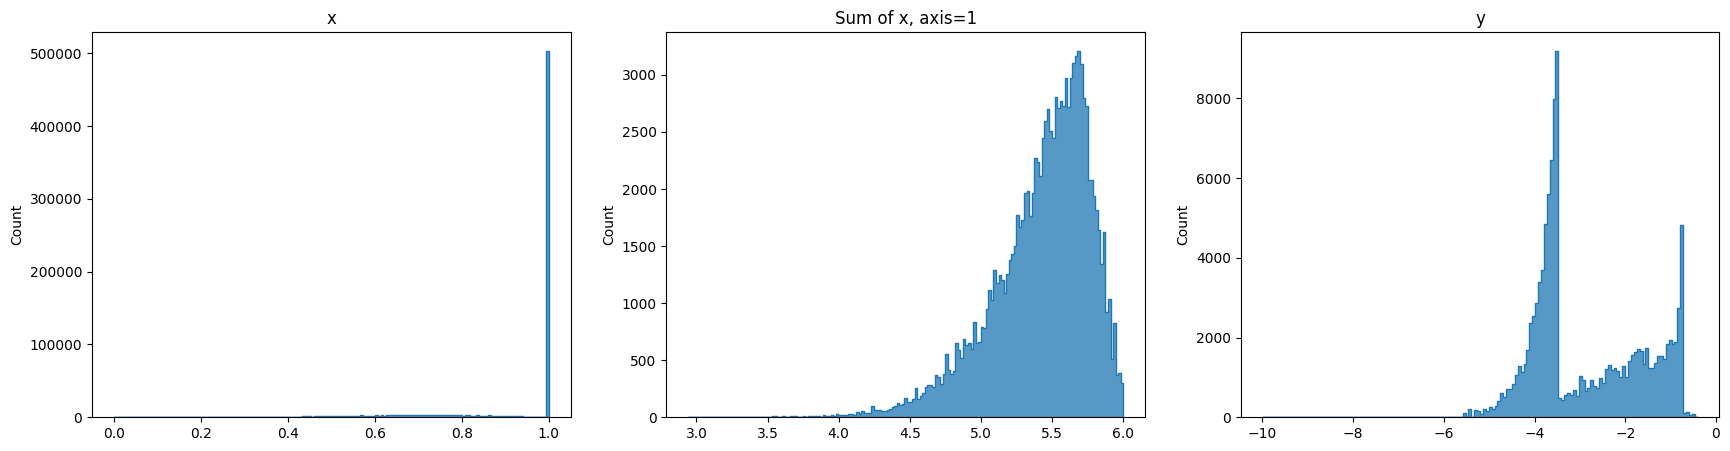

In [56]:
plt.figure(figsize=(3*7, 5))
ax = plt.subplot(1, 3, 1)
sns.histplot(x=x.flatten(), element='step', bins=150)
plt.title('x')
ax = plt.subplot(1, 3, 2)
sns.histplot(x=np.sum(x, axis=1).flatten(), element='step')
plt.title('Sum of x, axis=1')
ax = plt.subplot(1, 3, 3)
# y = data[filt]['sensitivity_wrt_species-6'].iloc[:TOTAL_DS].to_numpy()
# y = data[filt]['initial_steady_states'].iloc[:TOTAL_DS].to_numpy()
sns.histplot(x=y.flatten(), element='step', bins=150)
plt.title('y')

In [57]:

# Calculate the sparsity of the dataset
num_zeros = (x == 0).sum()
total_elements = np.size(x)
sparsity = num_zeros / total_elements

print(f"The sparsity of the dataset x: {sparsity:.4f}")

num_zeros = (y == 0).sum()
total_elements = np.size(y)
sparsity = num_zeros / total_elements

print(f"The sparsity of the dataset y: {sparsity:.4f}")

The sparsity of the dataset x: 0.0000
The sparsity of the dataset y: 0.0000


Text(0.5, 1.0, 'y')

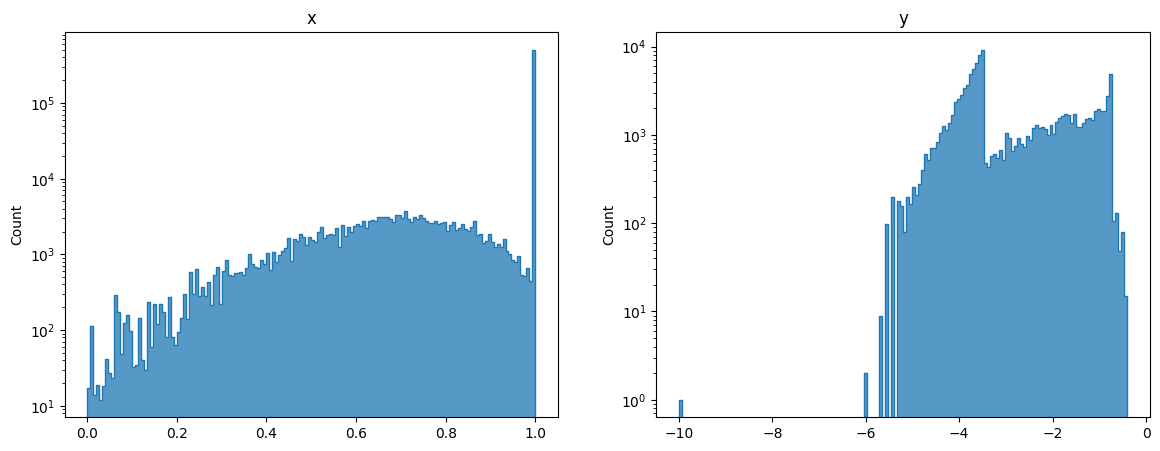

In [58]:
plt.figure(figsize=(2*7, 5))
ax = plt.subplot(1, 2, 1)
sns.histplot(x=x.flatten(), element='step', log_scale=[False, True], bins=150)
plt.title('x')
ax = plt.subplot(1, 2, 2)
sns.histplot(x=y.flatten(), element='step', log_scale=[False, True], bins=150)
plt.title('y')

### Initialise WandB 


In [60]:

wandb.init(
    # set the wandb project where this run will be logged
    project="mlp",
    # track hyperparameters and run metadata
    config={
        "architecture": "MLP",
        "dataset": "Circuits",
        "epochs": EPOCHS,
        "input_species": INPUT_SPECIES,
        "input_concat_diffs": input_concat_diffs,
        "input_concat_axis": input_concat_axis,
        "layer_sizes": LAYER_SIZES,
        "learning_rate": LEARNING_RATE,
        "learning_rate_schedule": LEARNING_RATE_SCHED,
        "n_head": N_HEAD,
        "seed": SEED,
        "target_circuit_function": target_circ_func,
        "total_dataset_size": TOTAL_DS,
        "train_split_percentage": train_split_perc,
        "use_categorical": USE_CATEGORICAL,
        "use_dropout": USE_DROPOUT,
        "use_L2_reg": USE_L2_REG,
        "use_warmup": USE_WARMUP,
        "warmup_epochs": WARMUP_EPOCHS
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: olivia-gallup (steel-lab). Use `wandb login --relogin` to force relogin


### Initialise model


In [61]:
model = hk.transform(partial(MLP_fn, init_kwargs={
                     'layer_sizes': LAYER_SIZES, 'n_head': N_HEAD, 'use_categorical': USE_CATEGORICAL}))

params = model.init(rng, x[:2])

/home/hslab/Olive/env_evo/lib/python3.8/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Text(0.5, 0.98, 'Initial weight distribution')

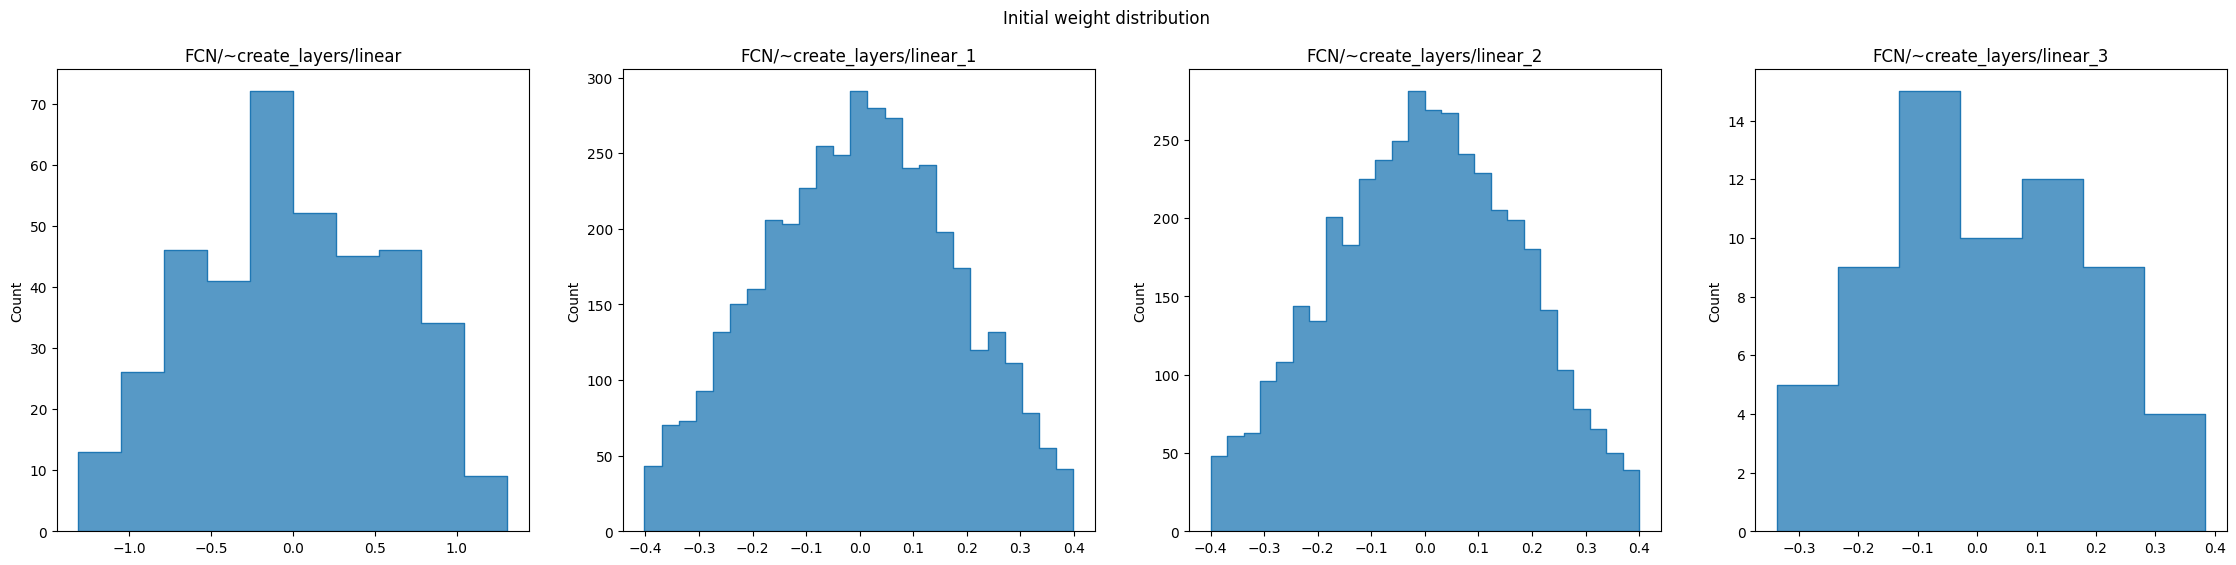

In [62]:
plt.figure(figsize=(7*len(params), 6))
for i in range(len(params)):
    ax = plt.subplot(1, len(params), i+1)
    sns.histplot(params[list(params.keys())[i]]['w'].flatten(), element='step')
    plt.title(list(params.keys())[i])
plt.suptitle('Initial weight distribution')

### Optimiser


In [63]:
if LEARNING_RATE_SCHED == 'cosine_decay':
    learning_rate_scheduler = optax.cosine_decay_schedule(
        LEARNING_RATE, decay_steps=EPOCHS, alpha=L2_REG_ALPHA)
else:
    learning_rate_scheduler = LEARNING_RATE
optimiser = optax.sgd(learning_rate=learning_rate_scheduler)

if USE_WARMUP:
    warmup_fn = optax.linear_schedule(
        init_value=0., end_value=LEARNING_RATE,
        transition_steps=WARMUP_EPOCHS * N_BATCHES)
    cosine_epochs = max(EPOCHS - WARMUP_EPOCHS, 1)
    cosine_fn = optax.cosine_decay_schedule(
        init_value=LEARNING_RATE,
        decay_steps=cosine_epochs * N_BATCHES)
    schedule_fn = optax.join_schedules(
        schedules=[warmup_fn, cosine_fn],
        boundaries=[WARMUP_EPOCHS * N_BATCHES])
    optimiser = optax.sgd(learning_rate=schedule_fn)

optimiser_state = optimiser.init(x)

## Train


In [64]:
def train_step(params, rng, model, x, y, optimiser, optimiser_state, l2_reg_alpha):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, l2_reg_alpha=l2_reg_alpha)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, loss, grads


def eval_step(params, rng, model: MLP, x, y, l2_reg_alpha):
    """ Return the average of loss and accuracy on validation data """
    # pred_y = model.apply(params, rng, x)
    # return accuracy_score(y, jnp.argmax(pred_y, axis=1))
    loss = loss_fn(params, rng, model, x, y, l2_reg_alpha=l2_reg_alpha)
    acc = compute_accuracy(params, rng, model, x, y)
    return acc, loss


def train(params, rng, model, x_train, y_train, x_val, y_val,
          optimiser, optimiser_state,
          l2_reg_alpha, epochs, batch_size: int,
          save_every: int = 50):
    saves = {}
    n_batches = (x_train.shape[0]//batch_size)+1
    for e in range(epochs):

        for batch in range(n_batches):
            start = int(batch*batch_size)
            end = int((batch+1)*batch_size) if batch != n_batches - 1 else None

            # Single batch of data
            x_batch, y_batch = x_train[start:end], y_train[start:end]

            if len(x_batch) and len(y_batch):
                params, train_loss, grads = train_step(
                    params, rng, model, x_batch, y_batch, optimiser, optimiser_state, l2_reg_alpha)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, l2_reg_alpha)

        if np.mod(e, save_every) == 0:
            saves[e] = {
                'params': params,
                'grads': grads,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_accuracy': val_acc
            }
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {train_loss}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')
            
    return params, saves

In [65]:
params, saves = train(params, rng, model, x_train, y_train, x_val, y_val, optimiser, optimiser_state,
                      l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS, batch_size=BATCH_SIZE,
                      save_every=PRINT_EVERY)  # int(STEPS // 15))

/tmp/ipykernel_3642737/1508687914.py:43: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(e, save_every) == 0:


Epoch 0 / 2 -		 Train loss: 1.2487866878509521	Val loss: 1.2077205181121826	Val accuracy: 0.022718854248523712
Epoch 1 / 2 -		 Train loss: 1.0207550525665283	Val loss: 0.9549875259399414	Val accuracy: 0.022065268829464912


## Visualise


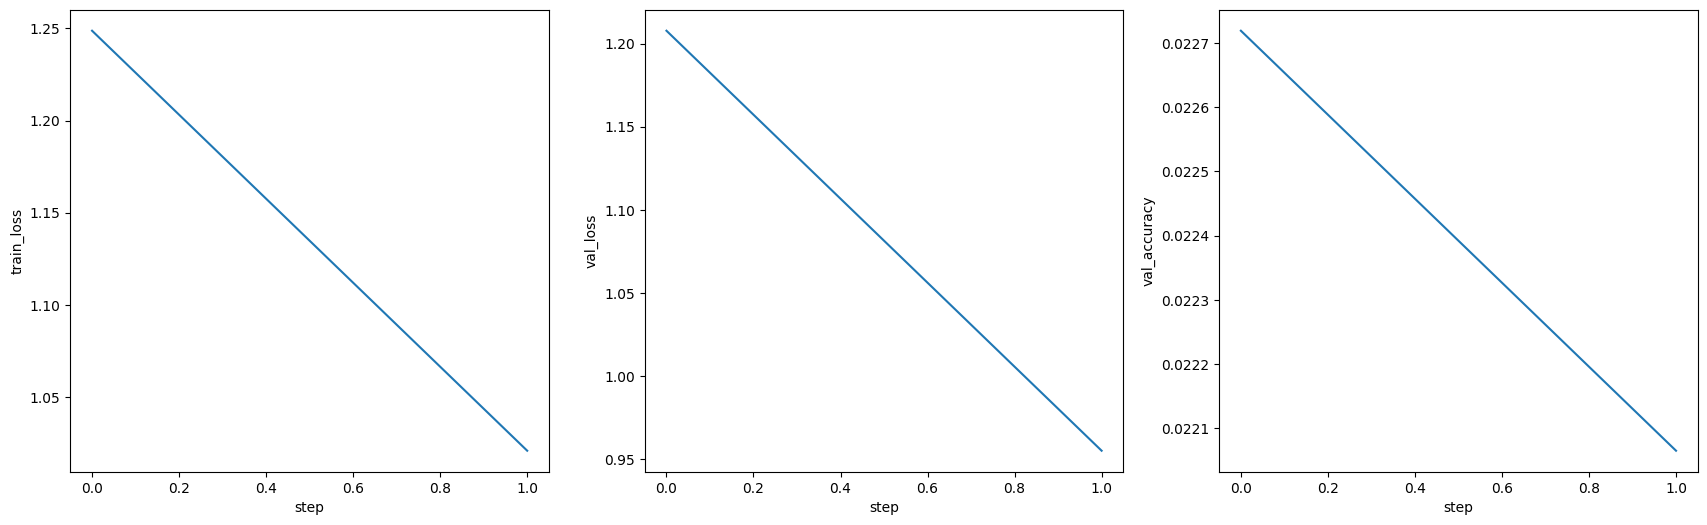

In [66]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

plt.savefig('training_summary.png')

The R2 score is  0.3523505877680755
The R2 score with weighted variance is  0.3523505877680755


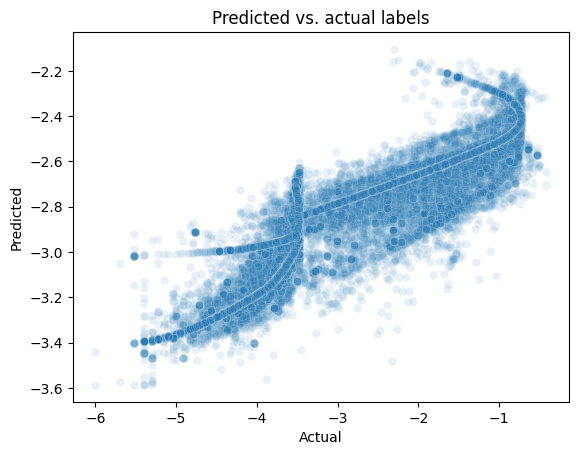

In [67]:
# params = arrayise(params)
predicted = model.apply(params, rng, x_val)
if USE_CATEGORICAL:
    predicted = jnp.argmax(predicted, axis=1)

sns.scatterplot(x=y_val, y=predicted.flatten(), alpha=0.1)
plt.title('Predicted vs. actual labels')
plt.ylabel('Predicted')
plt.xlabel('Actual')

print('The R2 score is ', r2_score(y_val, predicted))
print('The R2 score with weighted variance is ', r2_score(
    y_val, predicted, multioutput='variance_weighted'))

Text(0.5, 0.98, 'Grads: FCN/~create_layers/linear_2')

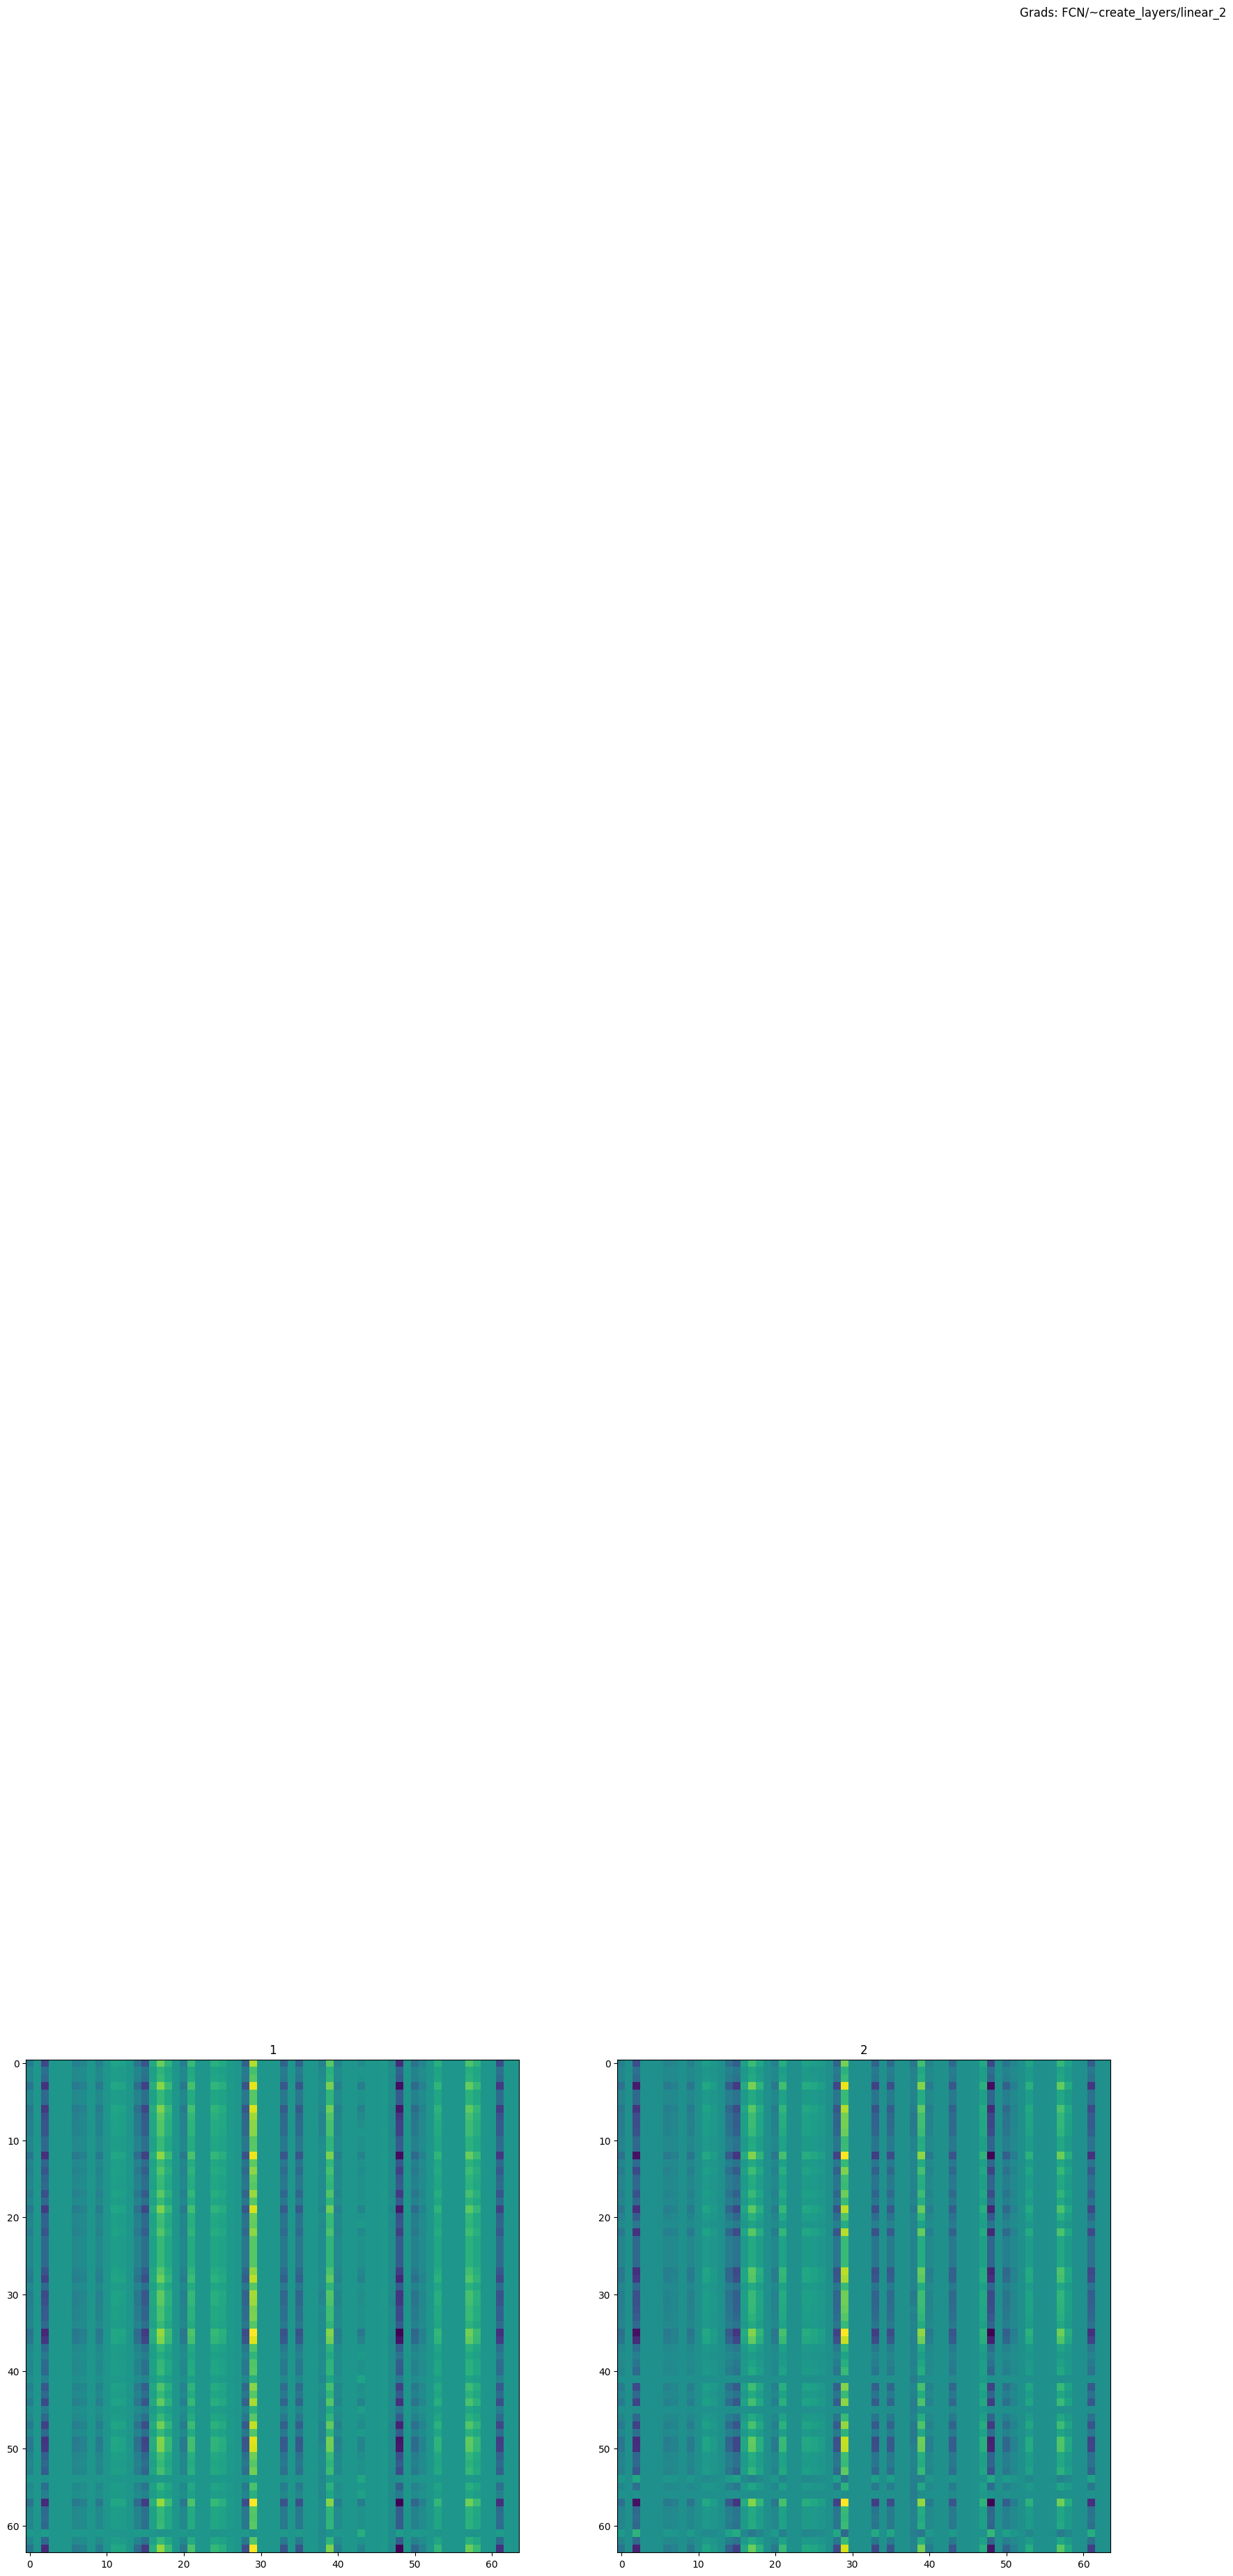

In [68]:
saves_grads = [v['grads'] for v in saves.values()]

plt.figure(figsize=(6*7, 20*6))
i = 1
layer_to_visualise = list(saves_grads[0].keys())[2]
for s in saves_grads:
    for v in [s[layer_to_visualise]]:
        ax = plt.subplot(len(saves_grads), 4, i)
        plt.imshow(v['w'])
        plt.title(i)
        i += 1
plt.suptitle(f'Grads: {layer_to_visualise}')

Text(0.5, 0.98, 'Param weights: FCN/~create_layers/linear_3')

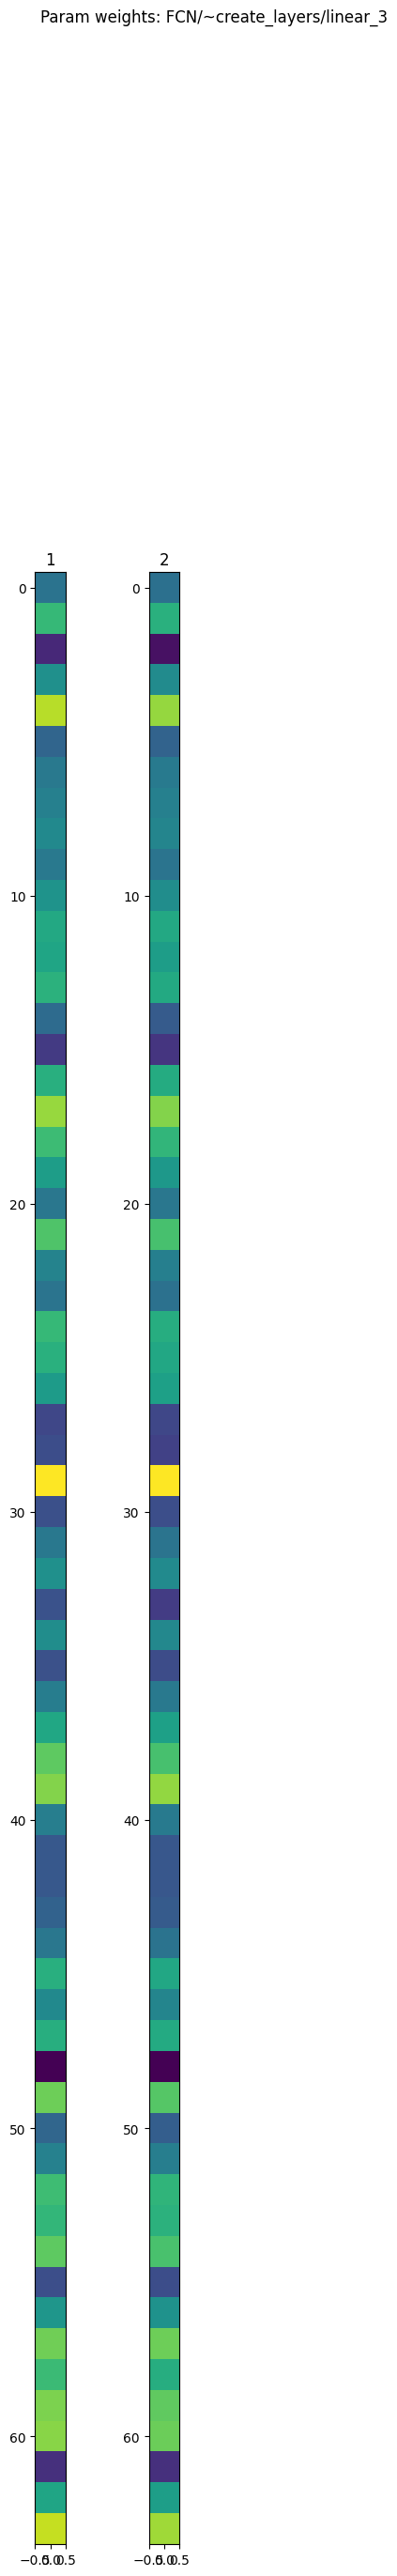

In [69]:
saves_params = [v['params'] for v in saves.values()]

plt.figure(figsize=(6*1, 10*6))
i = 1
layer_to_visualise = list(saves_params[0].keys())[3]
for s in saves_params:
    for v in [s[layer_to_visualise]]:
        ax = plt.subplot(len(saves_params), 4, i)
        plt.imshow(v['w'])
        plt.title(i)
        i += 1
plt.suptitle(f'Param weights: {layer_to_visualise}')

In [70]:
write_json(saves, out_path=save_path)

## Examine trained model


In [71]:
# saves_loaded = load_json_as_dict('saves')
# saves_loaded = load_json_as_dict('saves_20231016')
# saves_loaded = load_json_as_dict('saves_20231019')
saves_loaded = load_json_as_dict(save_path)


def arrayise(d):
    for k, v in d.items():
        if type(v) == dict:
            for kk, vv in v.items():
                d[k][kk] = jnp.array(vv)
    return d


step = list(saves_loaded.keys())[-1]
p = saves_loaded[str(step)]['params']
p = arrayise(p)

i = 0
pred_y = model.apply(p, rng, x[i], call_kwargs={'inference': True})

pred_y.shape

(1,)

In [72]:
pred_y = model.apply(p, rng, x)
if USE_CATEGORICAL:
    pred_y = jnp.argmax(pred_y, axis=1)
saves_loaded.keys()

dict_keys(['0', '1'])

The R2 score is  0.3521453358618718
The R2 score with weighted variance is  0.3521453358618718


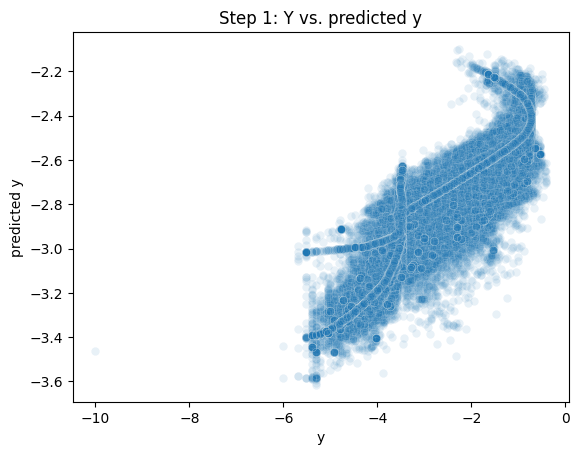

In [73]:
sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1)
plt.title(f'Step {step}: Y vs. predicted y')
plt.xlabel('y')
plt.ylabel('predicted y')

print('The R2 score is ', r2_score(y, pred_y))
print('The R2 score with weighted variance is ', r2_score(
    y, pred_y, multioutput='variance_weighted'))

In [74]:


# rows = int(np.ceil(np.sqrt(len(saves_loaded))))
# cols = int(np.ceil(np.sqrt(len(saves_loaded))))

# fig = plt.figure(figsize=(7*cols, 6*rows))
# for i, (step, v) in enumerate(saves_loaded.items()):
#     p = v['params']
#     p = arrayise(p)

#     pred_y = model.apply(p, rng, x)

#     ax = plt.subplot(rows, cols, i+1)
#     sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1)
#     plt.title(f'Step {step}: Y vs. predicted y')
#     plt.xlabel('y')
#     plt.ylabel('predicted y')

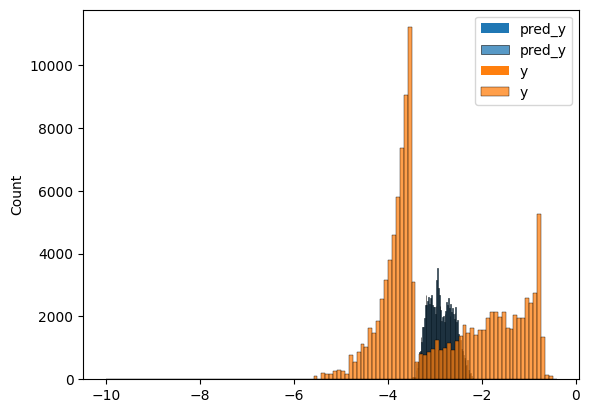

In [75]:

sns.histplot(pred_y.flatten(), label='pred_y')
sns.histplot(y, label='y')
plt.legend()

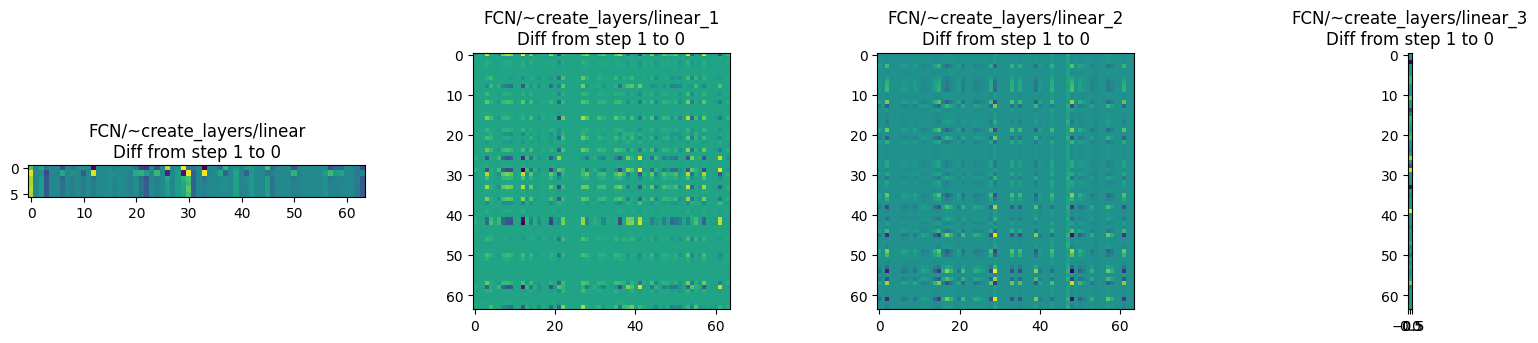

In [76]:

rows = len(saves_loaded.keys())
cols = len(p)
fig = plt.figure(figsize=(5*cols, 4*rows))
fig.subplots_adjust(hspace=0.4)
i = 0
diff_min = 0
diff_max = 0
for k0, k1 in zip(list(saves_loaded.keys())[:-1], list(saves_loaded.keys())[1:]):
    p0 = saves_loaded[k0]['params']
    p0 = arrayise(p0)
    p = saves_loaded[k1]['params']
    p = arrayise(p)

    for k, v0, v in zip(p0.keys(), p0.values(), p.values()):
        diff = v['w'] - v0['w']
        diff_min = np.min([diff_min, diff.min()])
        diff_max = np.max([diff_max, diff.max()])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(diff)
        # plt.imshow(v['w'])
        # plt.clim(diff_min, diff_max)
        i += 1
        plt.title(f'{k}\nDiff from step {k1} to {k0}')

/home/hslab/Olive/env_evo/lib/python3.8/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


The R2 score is  -7.473411079268509
The R2 score with weighted variance is  -7.473411079268509


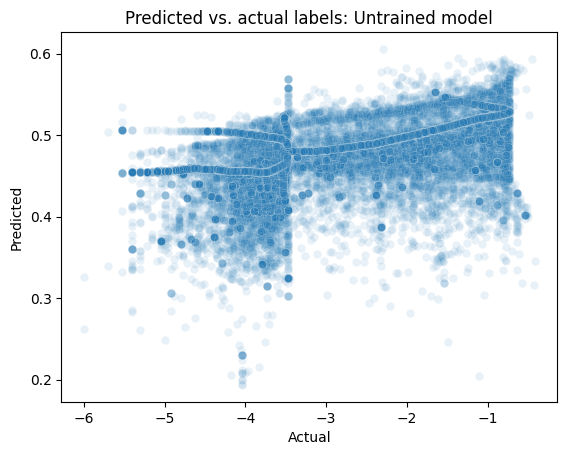

In [77]:
predicted = model.apply(model.init(rng, x[:2]), rng, x_val)
if USE_CATEGORICAL:
    predicted = jnp.argmax(predicted, axis=1)

sns.scatterplot(x=y_val, y=predicted.flatten(), alpha=0.1)
plt.title('Predicted vs. actual labels: Untrained model')
plt.ylabel('Predicted')
plt.xlabel('Actual')

print('The R2 score is ', r2_score(y_val, predicted))
print('The R2 score with weighted variance is ', r2_score(
    y_val, predicted, multioutput='variance_weighted'))

### TSNE


In [78]:
step = list(saves_loaded.keys())[-1]
p = saves_loaded[str(step)]['params']
p = arrayise(p)

pred_y = model.apply(p, rng, x_val)

In [79]:
x_og_val = xscaler.inverse_transform(x_val)

try:
    cols = list(map(str, np.arange(x.shape[-1])))
    df1 = pd.DataFrame(data=x_og_val, columns=cols)
    # df1['image'] = df1.apply(lambda row: wandb.Image(row.values.reshape(1, x_og_val.shape[-1])), axis=1)
    if USE_CATEGORICAL:
        df1['target'] = np.argmax(pred_y, axis=1)
    else:
        df1['target'] = pred_y
    df1['label'] = y_val
    df1['interacting'] = [str(np.round(i, 2)) for i in list(x_og_val)]
    df1['zeros_idxs'] = [''.join([str(ii) for ii in np.argwhere(
        i == 0).tolist()]).replace('[', '').replace(']', '') for i in list(x_og_val)]
    # df1['target'] = df1['target'].apply(str)
    # df1 = df1[df1.columns.tolist()[-2:] + df1.columns.tolist()[:-2]]

    wandb.log({"digits": df1})
except:
    print('nah')
wandb.finish()